In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
tf.__version__

'1.3.0'

In [3]:
from modules.spectral_pool_test import spectral_pool, max_pool
from modules.create_images import open_image, downscale_image

In [4]:
image = open_image('aj.jpg')
image = downscale_image(image, 256, 256).convert('RGB')

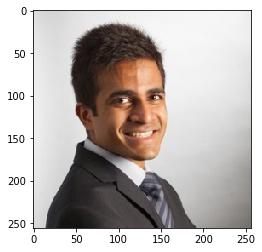

In [5]:
plt.imshow(image, cmap='gray')

In [6]:
im_np = np.asarray(image) / 255

In [7]:
im_np.shape

(256, 256, 3)

(256, 256, 1)
(192, 192, 1)
(192, 192, 1)


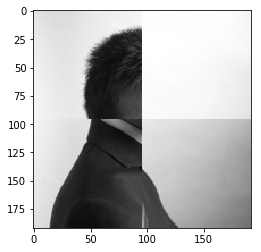

In [57]:
image_fft, image_new = spectral_pool(im_np, pool_size=64)
image_new = image_new * 255
image_new = np.absolute(image_new).squeeze()
plt.imshow(image_new, cmap='gray')

In [56]:
image_new.shape

(192, 192)

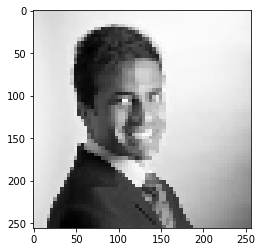

In [70]:
image_new_pool = max_pool(image, pool_size=4)
# image_new = image_new * 255
# image_new = np.absolute(image_new).squeeze()
plt.imshow(image_new_pool, cmap='gray')

In [64]:
image_new[np.arange(0,4), np.arange(0,4)]

array([ 0.,  0.,  0.,  0.], dtype=float32)

### Create Grid:

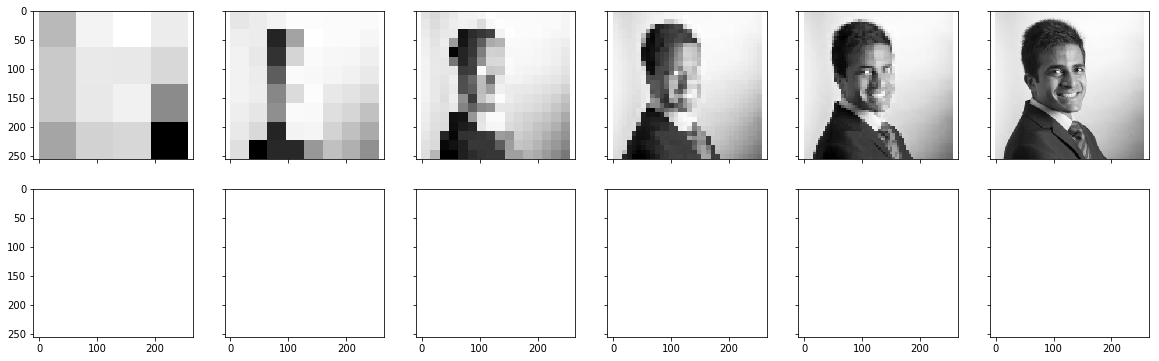

In [77]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6), sharex=True, sharey=True)
pool_size = [64, 32, 16, 8, 4, 1]
for i in range(6):
    im_pool = max_pool(image, pool_size=pool_size[i])
    ax[0, i].imshow(im_pool, cmap='gray')

## test code for implementing roll :

In [106]:
imt = open_image('aj.jpg')
imt = downscale_image(imt, 4, 4).convert('RGB')
imt = np.asarray(imt)/255

In [107]:
ft, imn = spectral_pool(imt, pool_size=2)

In [108]:
np.asarray(ft).shape

(4, 4, 1)

In [109]:
print(np.round(ft,2))

[[[ 0.74000001+0.j]
  [ 0.37000000+0.j]
  [ 0.86000001+0.j]
  [ 0.97000003+0.j]]

 [[ 0.69000000+0.j]
  [ 0.25999999+0.j]
  [ 0.80000001+0.j]
  [ 0.94000000+0.j]]

 [[ 0.73000002+0.j]
  [ 0.34999999+0.j]
  [ 0.81000000+0.j]
  [ 0.80000001+0.j]]

 [[ 0.38000000+0.j]
  [ 0.20000000+0.j]
  [ 0.52999997+0.j]
  [ 0.64999998+0.j]]]


In [111]:
imt2 = open_image('aj.jpg')
imt2 = downscale_image(imt2, 4, 4).convert('F')
imt2 = np.asarray(imt2)/255
ft2 = np.fft.fft2(imt2)

In [112]:
ft2

array([[ 10.08339219+0.j        ,  -0.46752942+2.177651j  ,
          0.97954126+0.j        ,  -0.46752942-2.177651j  ],
       [  0.24401569-0.91412945j,   0.19536869+0.11560774j,
         -0.13030589-0.23573725j,  -0.26670985-0.17827451j],
       [  1.19596465+0.j        ,   0.05377245-0.07761963j,
          0.28710978+0.j        ,   0.05377245+0.07761963j],
       [  0.24401569+0.91412945j,  -0.26670985+0.17827451j,
         -0.13030589+0.23573725j,   0.19536869-0.11560774j]])

In [113]:
np.fft.fftshift(ft2)

array([[  0.28710978+0.j        ,   0.05377245+0.07761963j,
          1.19596465+0.j        ,   0.05377245-0.07761963j],
       [ -0.13030589+0.23573725j,   0.19536869-0.11560774j,
          0.24401569+0.91412945j,  -0.26670985+0.17827451j],
       [  0.97954126+0.j        ,  -0.46752942-2.177651j  ,
         10.08339219+0.j        ,  -0.46752942+2.177651j  ],
       [ -0.13030589-0.23573725j,  -0.26670985-0.17827451j,
          0.24401569-0.91412945j,   0.19536869+0.11560774j]])

In [144]:
np.absolute(ft2)

array([[ 10.08339219,   2.22727359,   0.97954126,   2.22727359],
       [  0.94613758,   0.22701118,   0.26935418,   0.32080515],
       [  1.19596465,   0.09442607,   0.28710978,   0.09442607],
       [  0.94613758,   0.32080515,   0.26935418,   0.22701118]])

In [35]:
def tfshift(ft2, axis=1):
    matrix = tf.placeholder(shape=(256,256,3), dtype=tf.complex64)
    n, _, _ = matrix.get_shape().as_list()
    mid = (n + 1) // 2
    if axis == 1:
        start = [0, mid, 0]
        end = [-1, mid, -1]
    else:
        start = [mid, 0, 0]
        end = [mid, -1, -1]
    out = tf.concat([tf.slice(matrix, start, [-1, -1, -1]),
                     tf.slice(matrix, [0, 0, 0], end)], axis)
#     out = tf.slice(matrix, [0, 0, 0], end)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        out = sess.run([out], feed_dict={matrix: np.absolute(ft2)})
    return out

In [44]:
out = tfshift(tfshift(im_np)[0], 0)[0]
# plt.imshow(*255)

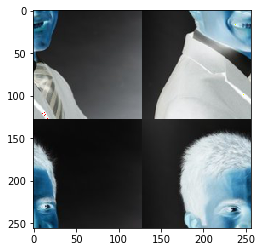

In [45]:
plt.imshow(np.absolute(out*255), cmap='gray')

In [167]:
ft3 = tfshift(ft2, 1)[0]
ft4 = tfshift(ft3, 1)[0]

In [168]:
np.absolute(ft4)

array([[ 10.08339214,   2.2272737 ,   0.97954124,   2.2272737 ],
       [  0.94613755,   0.22701117,   0.26935419,   0.32080516],
       [  1.19596469,   0.09442607,   0.28710979,   0.09442607],
       [  0.94613755,   0.32080516,   0.26935419,   0.22701117]], dtype=float32)

In [166]:
np.absolute(np.fft.fftshift(ft2))

array([[  0.28710978,   0.09442607,   1.19596465,   0.09442607],
       [  0.26935418,   0.22701118,   0.94613758,   0.32080515],
       [  0.97954126,   2.22727359,  10.08339219,   2.22727359],
       [  0.26935418,   0.32080515,   0.94613758,   0.22701118]])

In [122]:
t = tf.constant([[[1, 1, 1], [2, 2, 2]],
                 [[3, 3, 3], [4, 4, 4]],
                 [[5, 5, 5], [6, 6, 6]]])
x=1
t2 = tf.slice(t, [x, 0, 0], [1, 1, 3])
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    out = sess.run([t2])

In [123]:
out

[array([[[3, 3, 3]]], dtype=int32)]